Creating Combined Glove Vectors
training 0 0.94                                         
validation 0 0.935                                      
[0.6375     0.62924282 0.48601864 0.38864629 0.27531646 0.21238938
 0.1648855  0.13554987 0.09885932 0.02542373]
training 1 0.94                                         
validation 1 0.935                                      
[0.6375     0.62924282 0.48601864 0.38864629 0.27531646 0.21238938
 0.1648855  0.13554987 0.09885932 0.02542373]


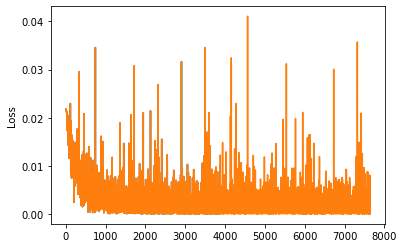

In [4]:
import numpy as np
import pickle, os, sys
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import bisect

loss_r = []

GLOVE_FILE = 'glove.6B.300d.txt'
TRAINING_FILE = 'wsj1-18.training'
VALIDATION_FILE = 'wsj19-21.truth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class pos_tagger(nn.Module):
    def __init__(self):
        super(pos_tagger, self).__init__()
        self.rnn = nn.LSTM(input_size = 350, hidden_size = 45, bidirectional=True)
        self.linear = nn.Linear(90, 45)
        self.softmax = nn.Softmax(-1)

    def forward(self, seq, hidden=None):
        output, _ = self.rnn(seq)
        output = self.softmax(self.linear(output))
        return output

def loadGloveModel(gloveFile):
    print('Creating Combined Glove Vectors')
    outname = gloveFile + '.pkl'
    if os.path.isfile(outname):
        model = pickle.load(open(outname,'rb'))
        #word_vec = pickle.load(open('model_prior_distribution.pyc','rb'))
    else:
        f = open(gloveFile,'r', encoding = 'utf-8')
        pickle_in = open('model_prior_distribution.pyc',"rb")
        word_vec = pickle.load(pickle_in)
        model = {}
        for line in f:
            splitLine = line.split()
            word = splitLine[0]
            if word in word_vec:
                embedding = np.array([float(val) for val in splitLine[1:]] +list(word_vec[word]))
            else:
                embedding = np.array([float(val) for val in splitLine[1:]] +[0]*50)
            model[word] = embedding
        pickle.dump(model, open(outname,'wb'))
    return model

def read_data(file):
    for line in open(file):
        tokens = line.strip().split()
        words = tokens[0::2]
        tags = tokens[1::2]
        yield list(zip(words,tags))

def main(argv):
    model = loadGloveModel(GLOVE_FILE)
    model_file = 'model.torch'

    tagger = pos_tagger().to(DEVICE)
    training_sentences = list(read_data(TRAINING_FILE))
    validation_sentences = list(read_data(VALIDATION_FILE))
    tags = set([tag.upper() for sentence in training_sentences for _, tag in sentence])
    tag_embeddings = dict([(tag, np.eye(len(tags))[idx]) for idx, tag in enumerate(tags)])
    num_train_sent = len(training_sentences)
    num_val_set = len(validation_sentences)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(tagger.parameters(),lr=0.0001)

    for epoch in range(2):
        if os.path.isfile(model_file):
            tagger = torch.load(model_file)
        for idx, sentence in enumerate(training_sentences):
            tagger.train()
            tagger.zero_grad()
            optimizer.zero_grad()

            words, tags = list(zip(*sentence))
            word_embeddings = np.array([model.get(word.lower(), np.zeros((350,))) for word in words])
            word_embeddings = torch.tensor(word_embeddings).float().reshape(-1,1,350).to(DEVICE)
            labels = np.array([tag_embeddings[tag] for tag in tags])
            labels = torch.tensor(labels).float().reshape(-1,1,45).to(DEVICE)

            output = tagger(word_embeddings)
            loss = criterion(labels, output)
            loss.backward()
            optimizer.step()
            if idx % 10 == 0:
                print(f'training {idx/num_train_sent:0.2f} {loss.item():0.5f}', end='\r')
                loss_r.append(loss.item())

        count = 0
        true = 0
        for idx, sentence in enumerate(training_sentences):
            tagger.eval()

            words, tags = list(zip(*sentence))
            word_embeddings = np.array([model.get(word.lower(), np.zeros((350,))) for word in words])
            word_embeddings = torch.tensor(word_embeddings).float().reshape(-1,1,350).to(DEVICE)
            labels = np.array([tag_embeddings[tag] for tag in tags])
            labels = torch.tensor(labels).float().reshape(-1,1,45).to(DEVICE)

            output = tagger(word_embeddings).cpu().detach().numpy().reshape(-1,45)
            output = np.array([np.where(x == np.amax(x))[0][0] for x in output])
            labels = labels.cpu().detach().numpy().reshape(-1,45)
            labels = np.array([np.where(x == np.amax(x)) for x in labels]).reshape(-1)

            count += len(labels)
            true += sum([int(x == y) for x, y in zip(output,labels)])

            if idx % 10 == 0:
                print(f'testing training set {idx/num_train_sent:0.2f}', end='\r')
        print(f'                                                        ', end='\r')
        print(f'training {epoch} {true/count:0.2f}')

        count = 0
        true = 0
        xax= np.arange(5,50,5)
        y = np.zeros(10)
        base = np.zeros(10)
        
        
        for idx, sentence in enumerate(validation_sentences):
            tagger.eval()

            words, tags = list(zip(*sentence))
            word_embeddings = np.array([model.get(word.lower(), np.zeros((350,))) for word in words])
            word_embeddings = torch.tensor(word_embeddings).float().reshape(-1,1,350).to(DEVICE)
            labels = np.array([tag_embeddings[tag] for tag in tags])
            labels = torch.tensor(labels).float().reshape(-1,1,45).to(DEVICE)

            output = tagger(word_embeddings).cpu().detach().numpy().reshape(-1,45)
            output = np.array([np.where(x == np.amax(x))[0][0] for x in output])
            labels = labels.cpu().detach().numpy().reshape(-1,45)
            labels = np.array([np.where(x == np.amax(x)) for x in labels]).reshape(-1)

            count += len(labels)
            true += sum([int(x == y) for x, y in zip(output,labels)])
            clen = len(labels)
            cpos = bisect.bisect(xax, clen)
            base[cpos] += 1
            if list(output) == list(labels):
                y[cpos] += 1 
            

            if idx % 10 == 0:
                print(f'testing validation set {idx/num_val_set:0.3f}', end='\r')
        print(f'                                                        ', end='\r')
        print(f'validation {epoch} {true/count:0.3f}')
        print(y/base)
        torch.save(tagger, 'model.torch')
        plt.plot(loss_r)
        plt.ylabel('Loss')
    


if __name__ == "__main__":
    main(sys.argv)

Text(0.5, 1.0, 'ACC vs Length, LSTM')

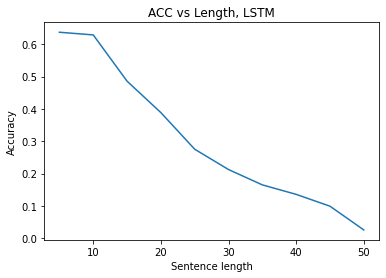

In [13]:
plt.plot(np.arange(5,55,5),[0.6375,0.62924282,0.48601864,0.38864629,0.27531646,0.21238938,
 0.1648855,0.13554987,0.09885932,0.02542373])
plt.xlabel('Sentence length')
plt.ylabel('Accuracy')
plt.title('ACC vs Length, LSTM')